<a href="https://colab.research.google.com/github/Danysan1/ai-unibo-nlp-project/blob/main/a2/execution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2 execution

In [67]:
%pip install pandas numpy matplotlib transformers==4.25.1  dataset tensorflow_addons

Note: you may need to restart the kernel to use updated packages.


## Data loading

### Dataset download

In [68]:
import os
import urllib.request
from tqdm import tqdm

class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)
        
def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def download_data(data_path, url_path, suffix):    
    if not os.path.exists(data_path):
        os.makedirs(data_path)
        
    data_path = os.path.join(data_path, f'{suffix}.json')
    if not os.path.exists(data_path):
        print(f"Downloading CoQA {suffix} data split... (it may take a while)")
        download_url(url=url_path, output_path=data_path)
        print("Download completed!")

In [69]:
data_folder = 'Dataset'

In [70]:
# Train & Validation data
train_url = "https://nlp.stanford.edu/data/coqa/coqa-train-v1.0.json"
download_data(data_path=data_folder, url_path=train_url, suffix='train')

# Test data
test_url = "https://nlp.stanford.edu/data/coqa/coqa-dev-v1.0.json"
download_data(data_path=data_folder, url_path=test_url, suffix='test')

### Dataset loading

In [71]:
import numpy as np
import pandas as pd
import json
from os import path
from matplotlib import pyplot as plt

In [72]:
def loadDataset(filename):
    with open(path.join(data_folder, filename)) as file_obj:
        df = json.load(file_obj)["data"]
    print(f'{len(df)} stories / {len(df[0]["questions"])} questions in the first row')

    storyDType = pd.CategoricalDtype(pd.unique([story["story"] for story in df]))
    print(f"{storyDType.categories.size} distinct stories")

    sourceDType = pd.CategoricalDtype(pd.unique([story["source"] for story in df]))
    print(f"{sourceDType.categories.size} distinct sources: {sourceDType.categories}")

    df = np.array([
        [
            sourceDType.categories.get_loc(story["source"]), # Sources factorization
            storyDType.categories.get_loc(story["story"]), # Sources factorization
            story["questions"][question_index]["input_text"],
            story["answers"][question_index]["input_text"],
            story["answers"][question_index]["span_text"],
        ]
        for story in df
        for question_index in range(len(story["questions"]))
        if story["answers"][question_index]["input_text"] != 'unknown'
    ])
    print(f'{df.shape} question-answer pairs x columns')
    print(f'First row: {df[0]}')
    
    # https://marcobonzanini.com/2021/09/15/tips-for-saving-memory-with-pandas/
    # https://pandas.pydata.org/docs/user_guide/categorical.html
    df = pd.DataFrame({
        "source": pd.Series(pd.Categorical.from_codes(df[:,0].astype(np.int16), dtype=sourceDType)),
        "p": pd.Series(pd.Categorical.from_codes(df[:,1].astype(np.int16), dtype=storyDType)),
        "q": df[:,2],
        "a": df[:,3],
        "span": df[:,4],
    })

    return df

In [73]:
train_df = loadDataset("train.json")
train_df.count()

7199 stories / 20 questions in the first row
6605 distinct stories
5 distinct sources: Index(['wikipedia', 'cnn', 'gutenberg', 'race', 'mctest'], dtype='object')
(107276, 5) question-answer pairs x columns
First row: ['0' '0' 'When was the Vat formally opened?'
 'It was formally established in 1475' 'Formally established in 1475']


source    107276
p         107276
q         107276
a         107276
span      107276
dtype: int64

In [74]:
pd.unique(train_df["p"]).size

6605

In [75]:
pd.unique(train_df["span"]).size

99470

In [76]:
pd.unique(train_df["source"]).size

5

In [77]:
train_df.head()

,source,p,q,a,span
0,wikipedia,"The Vatican Apostolic Library (), more commonl...",When was the Vat formally opened?,It was formally established in 1475,Formally established in 1475
1,wikipedia,"The Vatican Apostolic Library (), more commonl...",what is the library for?,research,he Vatican Library is a research library
2,wikipedia,"The Vatican Apostolic Library (), more commonl...",for what subjects?,"history, and law",Vatican Library is a research library for hist...
3,wikipedia,"The Vatican Apostolic Library (), more commonl...",and?,"philosophy, science and theology",Vatican Library is a research library for hist...
4,wikipedia,"The Vatican Apostolic Library (), more commonl...",what was started in 2014?,a project,"March 2014, the Vatican Library began an initi..."


In [78]:
train_df.memory_usage(deep=True)

Index          128
source      107764
p         14241201
q          9110271
a          7714559
span      12090637
dtype: int64

In [79]:
#test_df = loadDataset("test.json")
#test_df.count()

## Data Pre-Processing

### Check unanswerable questions in the Train Dataset

In [80]:
idx = (train_df.a == 'unknown')
unanswerable = train_df[idx]
unanswerable.q.count()

0

All unanswerable questions in the Train Dataset have been already removed.

## Exploratory Data Analysis

In [81]:
train_df["p"][42]

'CHAPTER VII. THE DAUGHTER OF WITHERSTEEN \n\n"Lassiter, will you be my rider?" Jane had asked him. \n\n"I reckon so," he had replied. \n\nFew as the words were, Jane knew how infinitely much they implied. She wanted him to take charge of her cattle and horse and ranges, and save them if that were possible. Yet, though she could not have spoken aloud all she meant, she was perfectly honest with herself. Whatever the price to be paid, she must keep Lassiter close to her; she must shield from him the man who had led Milly Erne to Cottonwoods. In her fear she so controlled her mind that she did not whisper this Mormon\'s name to her own soul, she did not even think it. Besides, beyond this thing she regarded as a sacred obligation thrust upon her, was the need of a helper, of a friend, of a champion in this critical time. If she could rule this gun-man, as Venters had called him, if she could even keep him from shedding blood, what strategy to play his flame and his presence against the g

In [82]:
train_df["q"][42]

'Was Lassiter impressed with the horse?'

In [83]:
train_df["a"][42]

'Yes'

In [84]:
train_df["span"][42]

'When Jerd led out this slender, beautifully built horse Lassiter suddenly became all eyes.'

In [85]:
train_df["source"][42]

'gutenberg'

### Distribution statistics

Sources:

<AxesSubplot:>

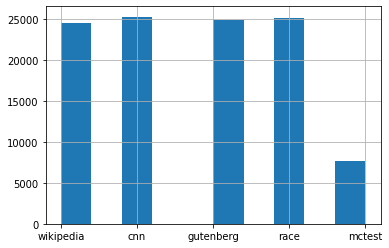

In [86]:
train_df["source"].hist()

Occurrences of 25 most popular stories:

<AxesSubplot:>

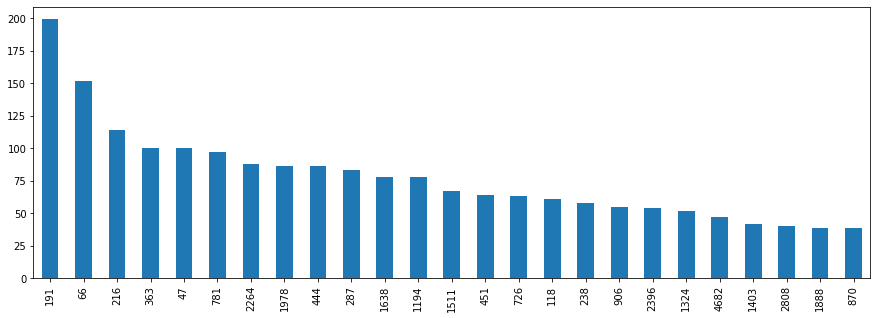

In [87]:
story_counts = train_df["p"].cat.codes.value_counts(sort=True)
story_counts[:25].plot(kind="bar", figsize=(15,5))

Occurrences of 25 least popular stories:

<AxesSubplot:>

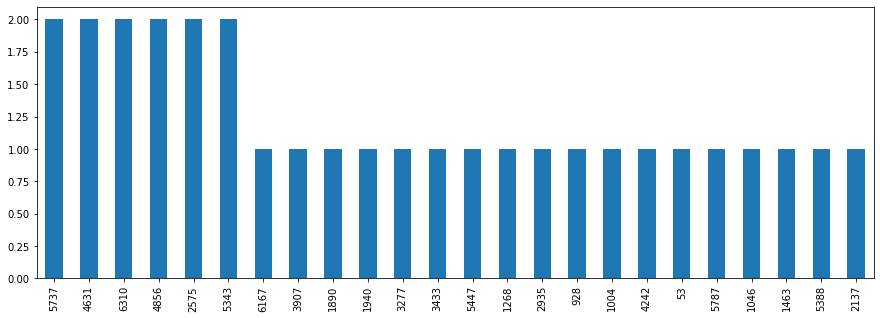

In [88]:
story_counts[-25:-1].plot(kind="bar", figsize=(15,5))

Histogram of story popularities:

<AxesSubplot:>

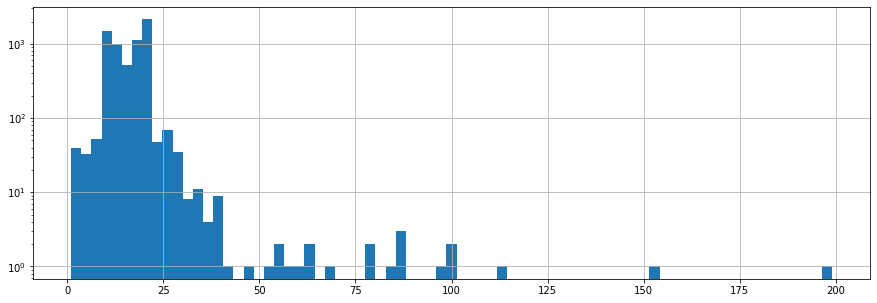

In [89]:
story_counts.hist(log=True,bins=75,figsize=(15,5))

### Removing rows with outlier story lengths to save memory

In [90]:
train_df.count()

source    107276
p         107276
q         107276
a         107276
span      107276
dtype: int64

LOGARITHMIC histogram of story length:

<AxesSubplot:>

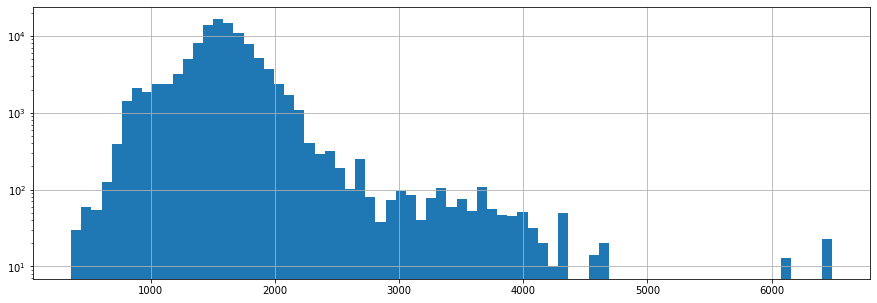

In [91]:
story_lengths = train_df["p"].str.len()
story_lengths.hist(log=True,bins=75,figsize=(15,5))

In [92]:
p_length_limit = story_lengths.quantile(0.999)
p_length_limit

4317.0

In [93]:
p_length_mask = story_lengths < p_length_limit
p_length_mask.value_counts()

True     107166
False       110
Name: p, dtype: int64

In [94]:
train_df = train_df[p_length_mask]
train_df.count()

source    107166
p         107166
q         107166
a         107166
span      107166
dtype: int64

### Removing rows with outlier question/answer/span lengths to save memory

LOGARITHMIC histogram of question length:

<AxesSubplot:>

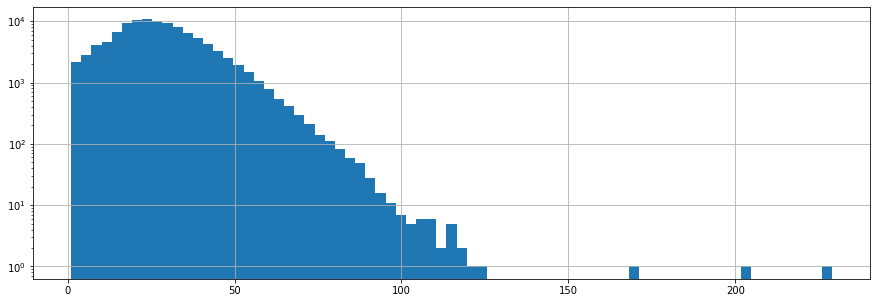

In [95]:
question_lengths = train_df["q"].str.len()
question_lengths.hist(log=True,bins=75,figsize=(15,5))

In [96]:
q_length_limit = question_lengths.quantile(0.999)
q_length_limit

89.0

LOGARITHMIC histogram of answer length:

<AxesSubplot:>

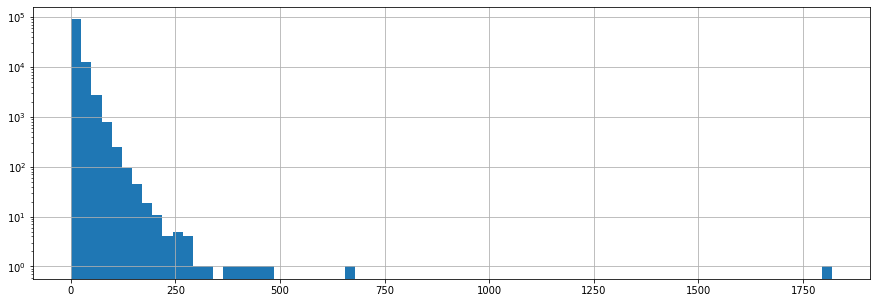

In [97]:
answer_lengths = train_df["a"].str.len()
answer_lengths.hist(log=True,bins=75,figsize=(15,5))

In [98]:
a_length_limit = answer_lengths.quantile(0.999)
a_length_limit

142.8350000000064

<AxesSubplot:>

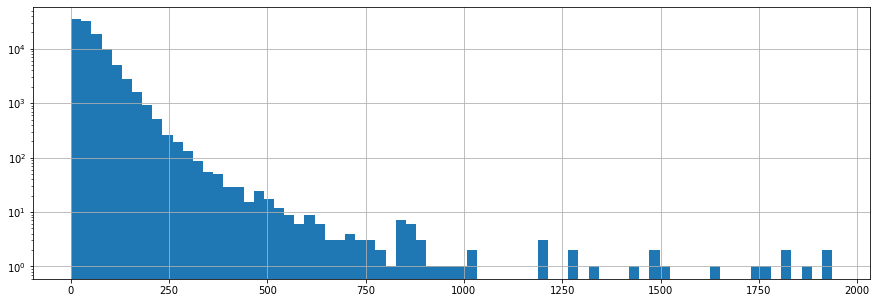

In [99]:
span_lengths = train_df["span"].str.len()
span_lengths.hist(log=True,bins=75,figsize=(15,5))

In [100]:
span_length_limit = span_lengths.quantile(0.999)
span_length_limit

502.5050000000192

In [101]:
bad_length_mask = (question_lengths > q_length_limit) | (answer_lengths > a_length_limit) | (span_lengths > span_length_limit)
bad_length_mask.value_counts()

False    106859
True        307
dtype: int64

In [102]:
excluded_stories = train_df["p"][bad_length_mask].unique()
len(excluded_stories)

272

In [103]:
excluded_mask = ~train_df["p"].isin(excluded_stories)
excluded_mask.value_counts()

True     102798
False      4368
Name: p, dtype: int64

In [104]:
train_df = train_df[excluded_mask]
train_df.count()

source    102798
p         102798
q         102798
a         102798
span      102798
dtype: int64

## Train-Validation-Test split

In [ ]:
# TODO

## Model definition

### Utilities

In [ ]:
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from typing import List, Dict, Callable
import random

2022-12-31 16:31:49.632965: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA

To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.

2022-12-31 16:31:51.065293: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory

2022-12-31 16:31:51.065318: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.

2022-12-31 16:31:51.204447: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered

2022-12-31 16:31:53.199587: W tensorflow/stream_executor/platfo

In [ ]:
def predict_data(model: keras.Model,
                x: np.ndarray,
                prediction_info: Dict):
    """
    Inference routine of a given input set of examples

    :param model: Keras built and possibly trained model
    :param x: input set of examples in np.ndarray format
    :param prediction_info: dictionary storing model predict() argument information

    :return
        predictions: predicted labels in np.ndarray format
    """
    print(f'Starting prediction: \n{prediction_info}')
    print(f'Predicting on {x.shape[0]} samples')
    predictions = model.predict(x, **prediction_info)
    return predictions

In [ ]:
def compute_f1(model: keras.Model, 
             x: np.ndarray, 
             y: np.ndarray):
    """
    Compute F1_score on the given data with corresponding labels

    :param model: Keras built and possibly trained model
    :param x: data in np.ndarray format
    :param y: ground-truth labels in np.ndarray format

    :return
        score: f1_macro_score
    """
    #predictions on the x set
    prediction_info = {
        'batch_size': 64,
        'verbose': 1
    }
    y_pred = predict_data(model=model, x=x, prediction_info=prediction_info)

    #compute argmax to take the best class for each sample
    y_pred = np.argmax(y_pred, axis=1)
    #compute the f1_macro
    score = f1_score(y, y_pred, average ='macro')
    return score

In [ ]:
def set_reproducibility(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
from tqdm import tqdm
from transformers import TFAutoModel, AutoTokenizer

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2022-12-31 16:31:57.309692: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node

Your kernel may have been built without NUMA support.

2022-12-31 16:31:57.309924: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory

2022-12-31 16:31:57.310131: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory

2022-12-31 16:31:57.310381: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory

2022-12-31 16:31:57.358632: W tensorflow/stream_executor/platform/default/dso_loader

### Question generation $f_\theta(P, Q)$ with text passage $P$ and question $Q$

### Seq2Seq LSTM

In [ ]:
class MyTrainer(object):
    """
    Simple wrapper class

    train_op -> uses tf.GradientTape to compute the loss
    batch_fit -> receives a batch and performs forward-backward passes (gradient included)
    """

    def __init__(self, encoder, decoder, max_length):
        self.encoder = encoder
        self.decoder = decoder
        self.max_length = max_length
        self.ce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-03)

    @tf.function
    def compute_loss(self, logits, target):
        loss = self.ce(y_true=target, y_pred=logits)
        mask = tf.logical_not(tf.math.equal(target, 0))
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_mean(loss)

    @tf.function
    def train_op(self, inputs):
        with tf.GradientTape() as tape:
            encoder_output, encoder_h, encoder_s = self.encoder({'input_ids': inputs['encoder_input_ids'],
                                                                 'hidden_state': inputs['encoder_state']})

            decoder_input = inputs['decoder_target'][:, :-1]  # ignore <end>
            real_target = inputs['decoder_target'][:, 1:]  # ignore <start>

            decoder.attention.setup_memory(encoder_output)

            decoder_initial_state = self.decoder.build_initial_state(decoder.batch_size, [encoder_h, encoder_s])
            predicted = self.decoder({'input_ids': decoder_input,
                                      'initial_state': decoder_initial_state}).rnn_output

            loss = self.compute_loss(logits=predicted, target=real_target)

        grads = tape.gradient(loss, self.encoder.trainable_variables + self.decoder.trainable_variables)
        return loss, grads

    @tf.function
    def batch_fit(self, inputs):
        loss, grads = self.train_op(inputs=inputs)
        self.optimizer.apply_gradients(zip(grads, self.encoder.trainable_variables + self.decoder.trainable_variables))
        return loss

    @tf.function
    def generate(self, input_ids):
        batch_size = input_ids.shape[0]
        encoder_initial_state = [tf.zeros((batch_size, self.encoder.encoder_units)),
                                 tf.zeros((batch_size, self.encoder.encoder_units))]
        encoder_output, encoder_h, encoder_s = self.encoder({
            'input_ids': input_ids,
            'hidden_state': encoder_initial_state
        })

        start_tokens = tf.fill([batch_size], tokenizer.word_index['<start>'])
        end_token = tokenizer.word_index['<end>']

        greedy_sampler = tfa.seq2seq.GreedyEmbeddingSampler()
        decoder_instance = tfa.seq2seq.BasicDecoder(cell=self.decoder.wrapped_decoder_cell,
                                                    sampler=greedy_sampler,
                                                    output_layer=self.decoder.generation_dense,
                                                    maximum_iterations=self.max_length)
        self.decoder.attention.setup_memory(encoder_output)

        decoder_initial_state = self.decoder.build_initial_state(batch_size, [encoder_h, encoder_s])
        decoder_embedding_matrix = self.decoder.embedding.variables[0]
        outputs, _, _ = decoder_instance(decoder_embedding_matrix,
                                         start_tokens=start_tokens,
                                         end_token=end_token,
                                         initial_state=decoder_initial_state)
        return outputs

    def translate(self, generated):
        return tokenizer.sequences_to_texts(generated.sample_id.numpy())


class Encoder(tf.keras.Model):

    def __init__(self, vocab_size, embedding_dim, encoder_units):
        super(Encoder, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.encoder_units = encoder_units

        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size,
                                                   output_dim=embedding_dim)
        self.encoder_lstm = tf.keras.layers.LSTM(self.encoder_units,
                                                 return_sequences=True,
                                                 return_state=True)

    def call(self, inputs, training=False, **kwargs):
        input_ids = inputs['input_ids']
        input_emb = self.embedding(input_ids)
        encoder_output, lstm_hidden, lstm_states = self.encoder_lstm(input_emb, initial_state=inputs['hidden_state'])
        return encoder_output, lstm_hidden, lstm_states

    def initialize(self, batch_size):
        return [tf.zeros((batch_size, self.encoder_units)), tf.zeros((batch_size, self.encoder_units))]


class Decoder(tf.keras.Model):

    def __init__(self, vocab_size, max_sequence_length, embedding_dim, decoder_units, batch_size):
        super(Decoder, self).__init__()

        self.max_sequence_length = max_sequence_length
        self.batch_size = batch_size

        self.decoder_units = decoder_units
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size,
                                                   output_dim=embedding_dim)
        self.decoder_lstm_cell = tf.keras.layers.LSTMCell(self.decoder_units)

        self.attention = tfa.seq2seq.BahdanauAttention(units=self.decoder_units,
                                                       memory=None,
                                                       memory_sequence_length=self.batch_size * [max_sequence_length])

        self.wrapped_decoder_cell = tfa.seq2seq.AttentionWrapper(self.decoder_lstm_cell,
                                                                 self.attention,
                                                                 attention_layer_size=self.decoder_units)

        self.generation_dense = tf.keras.layers.Dense(vocab_size)
        self.sampler = tfa.seq2seq.sampler.TrainingSampler()
        self.decoder = tfa.seq2seq.BasicDecoder(self.wrapped_decoder_cell,
                                                sampler=self.sampler,
                                                output_layer=self.generation_dense)

    def build_initial_state(self, batch_size, encoder_state):
        initial_state = self.wrapped_decoder_cell.get_initial_state(batch_size=batch_size, dtype=tf.float32)
        initial_state = initial_state.clone(cell_state=encoder_state)
        return initial_state

    def call(self, inputs, training=False, **kwargs):
        input_ids = inputs['input_ids']
        input_emb = self.embedding(input_ids)
        decoder_output, _, _ = self.decoder(input_emb,
                                            initial_state=inputs['initial_state'],
                                            sequence_length=self.batch_size * [self.max_sequence_length - 1])
        return decoder_output

In [ ]:
# Sample
input_sample = [
    "hello there how is it going",
    "this assignment is hellish"
]
output_sample = [
    "<start> it is going well <end>",
    "<start> I agree <end>"
]

batch_size = len(input_sample)

tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<UNK>')
tokenizer.fit_on_texts(input_sample + output_sample)

vocab_size = len(tokenizer.word_index) + 1

encoded_input_sample = tokenizer.texts_to_sequences(input_sample)
max_input_length = max([len(item) for item in encoded_input_sample])

encoded_output_sample = tokenizer.texts_to_sequences(output_sample)
max_output_length = max([len(item) for item in encoded_output_sample])

max_sequence_length = max(max_input_length, max_output_length)

encoded_input_sample = tf.keras.preprocessing.sequence.pad_sequences(encoded_input_sample,
                                                                        padding='post',
                                                                        maxlen=max_sequence_length)
encoded_output_sample = tf.keras.preprocessing.sequence.pad_sequences(encoded_output_sample,
                                                                        padding='post',
                                                                        maxlen=max_sequence_length)

# Test encoder
encoder = Encoder(vocab_size=vocab_size,
                    embedding_dim=50,
                    encoder_units=16)

sample_hidden = encoder.initialize(batch_size=batch_size)
encoder_sample_batch = {
    'input_ids': tf.convert_to_tensor(encoded_input_sample, dtype=tf.int32),
    'hidden_state': sample_hidden
}

sample_output, sample_h, sample_c = encoder(inputs=encoder_sample_batch)
print(f'{sample_output.shape} -- {sample_h.shape} -- {sample_c.shape}')

# Test decoder
decoder = Decoder(vocab_size=vocab_size,
                    embedding_dim=50,
                    decoder_units=16,
                    batch_size=batch_size,
                    max_sequence_length=max_sequence_length)
decoder.attention.setup_memory(sample_output)
initial_state = decoder.build_initial_state(batch_size, [sample_h, sample_c])

decoder_sample_batch = {
    'input_ids': tf.convert_to_tensor(encoded_output_sample, tf.int32),
    'initial_state': initial_state
}
sample_decoder_outputs = decoder(decoder_sample_batch).rnn_output
print(f'{sample_decoder_outputs.shape}')

2022-12-31 16:31:57.526536: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA

To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(2, 6, 16) -- (2, 16) -- (2, 16)

(2, 5, 16)


In [ ]:
# Training
trainer = MyTrainer(encoder=encoder,
                    decoder=decoder,
                    max_length=max_sequence_length)

In [ ]:
epochs = 100
for epoch in tqdm(range(epochs)):
    encoder_hidden_state = encoder.initialize(batch_size=batch_size)
    batch = {
        'encoder_input_ids': encoded_input_sample,
        'encoder_state': encoder_hidden_state,
        'decoder_target': encoded_output_sample
    }
    loss = trainer.batch_fit(batch)
    print(f'Loss - {loss}')

    generated = trainer.generate(input_ids=encoded_input_sample)
    translated = trainer.translate(generated)
    print(f'Translated - {translated}')

  0%|          | 0/100 [00:00<?, ?it/s]

Loss - 2.215960741043091


  6%|▌         | 6/100 [00:07<01:30,  1.03it/s]

Translated - ['it it <end> this <UNK> it', 'going i agree agree it it']

Loss - 2.2101049423217773

Translated - ['it it it <end> this it', 'i agree agree it it <end>']

Loss - 2.204186201095581

Translated - ['it it it it it it', 'i agree it it <end> agree']

Loss - 2.1981472969055176

Translated - ['it it it it it it', 'i agree it it <end> <end>']

Loss - 2.1919312477111816

Translated - ['it it it it it it', 'i agree it it <end> <end>']

Loss - 2.18548583984375

Translated - ['it it it it it it', 'i agree it it <end> <end>']

Loss - 2.1787631511688232

Translated - ['it it it it it it', 'i agree it it <end> <end>']

Loss - 2.1717166900634766

Translated - ['it it it it it it', 'i <end> agree <end> <end> <end>']

Loss - 2.1643009185791016

Translated - ['it it it it it it', 'i <end> <end> agree <end> <end>']

Loss - 2.1564693450927734

Translated - ['it it it it it it', 'i <end> <end> <end> <end> <end>']


 16%|█▌        | 16/100 [00:08<00:21,  3.91it/s]

Loss - 2.1481735706329346

Translated - ['it it it it it it', 'it it it it it it']

Loss - 2.13936185836792

Translated - ['it it it it it it', 'it it it it it it']

Loss - 2.129979133605957

Translated - ['it it it it it it', 'it it it it it it']

Loss - 2.119966506958008

Translated - ['it it it it it it', 'it it it it it it']

Loss - 2.1092593669891357

Translated - ['it it it it it it', 'it it it it it it']

Loss - 2.097790241241455

Translated - ['it it it it it it', 'it it it it it it']

Loss - 2.085484027862549

Translated - ['it it it it it it', 'it it it it it it']

Loss - 2.0722622871398926

Translated - ['it it it it it it', 'it it it it it it']

Loss - 2.058039903640747

Translated - ['it it it it it it', 'it it it it it it']


 27%|██▋       | 27/100 [00:08<00:07,  9.34it/s]

Loss - 2.0427277088165283

Translated - ['it it it it it it', 'it it it it it it']

Loss - 2.026232957839966

Translated - ['it it it it it it', 'it it it it it it']

Loss - 2.008460283279419

Translated - ['it it it it it it', 'it it it it it it']

Loss - 1.989315390586853

Translated - ['it it it it it it', 'it it it it <end> <end>']

Loss - 1.9687080383300781

Translated - ['it it it it it it', 'it it it <end> <end> <end>']

Loss - 1.946556806564331

Translated - ['it it it it it it', 'it it <end> <end> <end> <end>']

Loss - 1.9227972030639648

Translated - ['it it it it it it', 'it it <end> <end> <end> <end>']

Loss - 1.8973890542984009

Translated - ['it it it it it it', 'it it <end> <end> <end> <end>']

Loss - 1.8703285455703735

Translated - ['it it it it it it', 'it it <end> <end> <end> <end>']

Loss - 1.8416589498519897

Translated - ['it it it it it it', 'it it <end> <end> <end> <end>']

Loss - 1.8114821910858154


 38%|███▊      | 38/100 [00:08<00:03, 17.24it/s]

Translated - ['it it it it it <end>', 'it <end> <end> <end> <end> <end>']

Loss - 1.7799694538116455

Translated - ['it it it it <end>', 'it <end> <end> <end> <end>']

Loss - 1.7473640441894531

Translated - ['it it it <end>', 'it <end> <end> <end>']

Loss - 1.7139848470687866

Translated - ['it it it <end>', 'it <end> <end> <end>']

Loss - 1.6802200078964233

Translated - ['it it it <end>', 'it <end> <end> <end>']

Loss - 1.6465171575546265

Translated - ['it it <end>', 'it <end> <end>']

Loss - 1.6133644580841064

Translated - ['it it <end>', 'it <end> <end>']

Loss - 1.5812695026397705

Translated - ['it it <end>', 'it <end> <end>']

Loss - 1.5507242679595947

Translated - ['it it <end>', 'it <end> <end>']

Loss - 1.5221532583236694

Translated - ['it it <end>', 'it <end> <end>']

Loss - 1.4958441257476807

Translated - ['it <end>', 'it <end>']


 48%|████▊     | 48/100 [00:08<00:02, 25.79it/s]

Loss - 1.4718739986419678

Translated - ['it <end>', 'it <end>']

Loss - 1.4500696659088135

Translated - ['it <end>', 'it <end>']

Loss - 1.430027723312378

Translated - ['it <end>', 'it <end>']

Loss - 1.4111862182617188

Translated - ['it <end>', 'it <end>']

Loss - 1.392928123474121

Translated - ['it <end>', 'it <end>']

Loss - 1.374693751335144

Translated - ['it <end>', 'it <end>']

Loss - 1.3560700416564941

Translated - ['it <end>', 'it <end>']

Loss - 1.3368308544158936

Translated - ['it <end>', 'it <end>']

Loss - 1.3169281482696533

Translated - ['it <end>', 'it <end>']

Loss - 1.2964471578598022

Translated - ['it <end>', 'it <end>']

Loss - 1.2755507230758667

Translated - ['it <end>', 'it <end>']


 60%|██████    | 60/100 [00:08<00:01, 36.27it/s]

Loss - 1.254421591758728

Translated - ['it <end>', 'it <end>']

Loss - 1.233214259147644

Translated - ['it <end>', 'it <end>']

Loss - 1.2120234966278076

Translated - ['it it well <end>', 'it <end> <end> <end>']

Loss - 1.190889596939087

Translated - ['it it well <end>', 'it <end> <end> <end>']

Loss - 1.1698271036148071

Translated - ['it it well <end>', 'it <end> <end> <end>']

Loss - 1.148860216140747

Translated - ['it it well <end>', 'i <end> <end> <end>']

Loss - 1.128030776977539

Translated - ['it it well <end>', 'i <end> <end> <end>']

Loss - 1.1073830127716064

Translated - ['it is well <end>', 'i <end> <end> <end>']

Loss - 1.086936593055725

Translated - ['it going well <end>', 'i <end> <end> <end>']

Loss - 1.0666611194610596

Translated - ['it going well <end>', 'i agree <end> <end>']

Loss - 1.046464204788208

Translated - ['it going going <end>', 'i agree <end> <end>']


 73%|███████▎  | 73/100 [00:09<00:00, 46.34it/s]

Loss - 1.026198387145996

Translated - ['it going going <end>', 'i agree <end> <end>']

Loss - 1.0056911706924438

Translated - ['it going going <end>', 'i agree <end> <end>']

Loss - 0.9847881197929382

Translated - ['it going going <end>', 'i agree <end> <end>']

Loss - 0.9633939862251282

Translated - ['it going going <end>', 'i agree <end> <end>']

Loss - 0.9414979815483093

Translated - ['it going going <end>', 'i agree <end> <end>']

Loss - 0.9191766977310181

Translated - ['it going going <end>', 'i agree <end> <end>']

Loss - 0.8965771794319153

Translated - ['it going going <end>', 'i agree <end> <end>']

Loss - 0.8738818168640137

Translated - ['it going going well <end>', 'i agree <end> <end> <end>']

Loss - 0.8512600660324097

Translated - ['it going going well <end>', 'i agree <end> <end> <end>']

Loss - 0.8288224935531616

Translated - ['it going going well <end>', 'i agree <end> <end> <end>']

Loss - 0.8066062927246094

Translated - ['it going going well <end>', 'i agree

 86%|████████▌ | 86/100 [00:09<00:00, 52.82it/s]

Translated - ['it going going well <end>', 'i agree <end> <end> <end>']

Loss - 0.7412184476852417

Translated - ['it going going well <end>', 'i agree <end> <end> <end>']

Loss - 0.7199094295501709

Translated - ['it is going well <end>', 'i agree <end> <end> <end>']

Loss - 0.6989539861679077

Translated - ['it is going well <end>', 'i agree <end> <end> <end>']

Loss - 0.6784437894821167

Translated - ['it is going well <end>', 'i agree <end> <end> <end>']

Loss - 0.6584662199020386

Translated - ['it is going well <end>', 'i agree <end> <end> <end>']

Loss - 0.6390868425369263

Translated - ['it is going well <end>', 'i agree <end> <end> <end>']

Loss - 0.6203412413597107

Translated - ['it is going well <end>', 'i agree <end> <end> <end>']

Loss - 0.6022309064865112

Translated - ['it is going well <end>', 'i agree <end> <end> <end>']

Loss - 0.5847277641296387

Translated - ['it is going well <end>', 'i agree <end> <end> <end>']

Loss - 0.567787766456604

Translated - ['it is goin

100%|██████████| 100/100 [00:09<00:00, 10.44it/s]

Loss - 0.5199663043022156

Translated - ['it is going well <end>', 'i agree <end> <end> <end>']

Loss - 0.5049706101417542

Translated - ['it is going well <end>', 'i agree <end> <end> <end>']

Loss - 0.49044856429100037

Translated - ['it is going well <end>', 'i agree <end> <end> <end>']

Loss - 0.47640281915664673

Translated - ['it is going well <end>', 'i agree <end> <end> <end>']

Loss - 0.46282821893692017

Translated - ['it is going well <end>', 'i agree <end> <end> <end>']

Loss - 0.44971227645874023

Translated - ['it is going well <end>', 'i agree <end> <end> <end>']

Loss - 0.43703755736351013

Translated - ['it is going well <end>', 'i agree <end> <end> <end>']

Loss - 0.4247874319553375

Translated - ['it is going well <end>', 'i agree <end> <end> <end>']

Loss - 0.41294923424720764

Translated - ['it is going well <end>', 'i agree <end> <end> <end>']

Loss - 0.40151482820510864

Translated - ['it is going well <end>', 'i agree <end> <end> <end>']

Loss - 0.39047947525978

In [ ]:
#TODO

### Seq2Seq Bert-Tiny

In [ ]:
class MyTrainer(object):
    """
    Simple wrapper class

    train_op -> uses tf.GradientTape to compute the loss
    batch_fit -> receives a batch and performs forward-backward passes (gradient included)
    """

    def __init__(self, encoder, decoder, max_length):
        self.encoder = encoder
        self.decoder = decoder
        self.max_length = max_length
        self.ce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-03)

    @tf.function
    def compute_loss(self, logits, target):
        loss = self.ce(y_true=target, y_pred=logits)
        mask = tf.logical_not(tf.math.equal(target, 0))
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_mean(loss)

    @tf.function
    def train_op(self, inputs):
        with tf.GradientTape() as tape:
            encoder_output, encoder_h, encoder_s = self.encoder({'input_ids': inputs['encoder_input_ids'],
                                                                 'attention_mask': inputs['encoder_attention_mask']})

            decoder_input = inputs['decoder_target'][:, :-1]  # ignore <end>
            real_target = inputs['decoder_target'][:, 1:]  # ignore <start>

            decoder.attention.setup_memory(encoder_output)

            decoder_initial_state = self.decoder.build_initial_state(decoder.batch_size, [encoder_h, encoder_s])
            predicted = self.decoder({'input_ids': decoder_input,
                                      'initial_state': decoder_initial_state}).rnn_output

            loss = self.compute_loss(logits=predicted, target=real_target)

        grads = tape.gradient(loss, self.encoder.trainable_variables + self.decoder.trainable_variables)
        return loss, grads

    @tf.function
    def batch_fit(self, inputs):
        loss, grads = self.train_op(inputs=inputs)
        self.optimizer.apply_gradients(zip(grads, self.encoder.trainable_variables + self.decoder.trainable_variables))
        return loss

    # @tf.function
    def generate(self, input_ids, attention_mask=None):
        batch_size = input_ids.shape[0]
        encoder_output, encoder_h, encoder_s = self.encoder({
            'input_ids': input_ids,
            'attention_mask': attention_mask
        })

        start_tokens = tf.fill([batch_size], output_tokenizer.word_index['<start>'])
        end_token = output_tokenizer.word_index['<end>']

        greedy_sampler = tfa.seq2seq.GreedyEmbeddingSampler()
        decoder_instance = tfa.seq2seq.BasicDecoder(cell=self.decoder.wrapped_decoder_cell,
                                                    sampler=greedy_sampler,
                                                    output_layer=self.decoder.generation_dense,
                                                    maximum_iterations=self.max_length)
        self.decoder.attention.setup_memory(encoder_output)

        decoder_initial_state = self.decoder.build_initial_state(batch_size, [encoder_h, encoder_s])
        decoder_embedding_matrix = self.decoder.embedding.variables[0]
        outputs, _, _ = decoder_instance(decoder_embedding_matrix,
                                         start_tokens=start_tokens,
                                         end_token=end_token,
                                         initial_state=decoder_initial_state)
        return outputs

    def translate(self, generated):
        return output_tokenizer.sequences_to_texts(generated.sample_id.numpy())


class Encoder(tf.keras.Model):

    def __init__(self, model_name, decoder_units):
        super(Encoder, self).__init__()
        self.model = TFAutoModel.from_pretrained(model_name, from_pt=True)
        self.reducer = tf.keras.layers.Dense(decoder_units)

    def call(self, inputs, training=False, **kwargs):
        model_output = self.model(inputs)
        all_outputs = model_output[0]
        pooled_output = model_output[1]
        pooled_output = self.reducer(pooled_output)
        return all_outputs, pooled_output, pooled_output


class Decoder(tf.keras.Model):

    def __init__(self, vocab_size, max_sequence_length, embedding_dim, decoder_units, batch_size):
        super(Decoder, self).__init__()

        self.max_sequence_length = max_sequence_length
        self.batch_size = batch_size

        self.decoder_units = decoder_units
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size,
                                                   output_dim=embedding_dim)
        self.decoder_lstm_cell = tf.keras.layers.LSTMCell(self.decoder_units)

        self.attention = tfa.seq2seq.BahdanauAttention(units=self.decoder_units,
                                                       memory=None,
                                                       memory_sequence_length=self.batch_size * [max_sequence_length])

        self.wrapped_decoder_cell = tfa.seq2seq.AttentionWrapper(self.decoder_lstm_cell,
                                                                 self.attention,
                                                                 attention_layer_size=self.decoder_units)

        self.generation_dense = tf.keras.layers.Dense(vocab_size)
        self.sampler = tfa.seq2seq.sampler.TrainingSampler()
        self.decoder = tfa.seq2seq.BasicDecoder(self.wrapped_decoder_cell,
                                                sampler=self.sampler,
                                                output_layer=self.generation_dense)

    def build_initial_state(self, batch_size, encoder_state):
        initial_state = self.wrapped_decoder_cell.get_initial_state(batch_size=batch_size, dtype=tf.float32)
        initial_state = initial_state.clone(cell_state=encoder_state)
        return initial_state

    def call(self, inputs, training=False, **kwargs):
        input_ids = inputs['input_ids']
        input_emb = self.embedding(input_ids)
        decoder_output, _, _ = self.decoder(input_emb,
                                            initial_state=inputs['initial_state'],
                                            sequence_length=self.batch_size * [self.max_sequence_length - 1])
        return decoder_output


In [ ]:
from transformers import BertForQuestionAnswering, AutoTokenizer, AutoConfig

model_name = 'prajjwal1/bert-tiny'

#config = AutoConfig.from_pretrained(model_name)
#model = BertForQuestionAnswering.from_pretrained(model_name, config=config)
input_tokenizer = AutoTokenizer.from_pretrained(model_name)

The next block of code is an example of encoding of a question-context pair: in this case, the question is the first part of the encoding, and the context is the second part. There are two special tokens: [CLS] token at the start of the encoding, [SEP] token between the question and the context, and at the end of the encoding.

In this case the context is the *span*, to provide a better example that explains the encoding.

In [ ]:
line = 42

encoded_question = input_tokenizer(train_df['q'][line], return_tensors='tf', padding=True)
print(train_df['q'][line])

encoded_span = input_tokenizer(train_df['span'][line], return_tensors='tf', padding=True)
print(train_df['span'][line])

encoded_qs = input_tokenizer(train_df['q'][line], train_df['span'][line], return_tensors='tf', padding=True)

print('= '*40)
for idx, tok in zip(encoded_qs.input_ids.numpy()[0], input_tokenizer.convert_ids_to_tokens(encoded_qs.input_ids[0])):
    print("{}\t{}".format(idx, tok))

Was Lassiter impressed with the horse?

When Jerd led out this slender, beautifully built horse Lassiter suddenly became all eyes.

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 

101	[CLS]

2001	was

27333	lass

21646	##iter

7622	impressed

2007	with

1996	the

3586	horse

1029	?

102	[SEP]

2043	when

15333	je

4103	##rd

2419	led

2041	out

2023	this

10944	slender

1010	,

17950	beautifully

2328	built

3586	horse

27333	lass

21646	##iter

3402	suddenly

2150	became

2035	all

2159	eyes

1012	.

102	[SEP]


Lets encode a part of the dataset in sentences of: [CLS] question [SEP] passage [SEP]. Otherwise, the training would be very slow.

In [ ]:
max_length = 512  # The maximum length of a feature (question and context)
doc_stride = (
    128  # The authorized overlap between two part of the context when splitting
)
sentences = 20
sample = 10

In [ ]:
# Input
qs = train_df['q'][range(sentences)] # questions
cs = train_df['p'][range(sentences)] # contexts

batch_size = len(qs)

encoded_inputs = input_tokenizer(
    qs.values.tolist(),
    cs.values.tolist(),
    #train_df['q'].values.tolist(),
    #train_df['p'].values.tolist(),
    truncation="only_second",
    max_length=max_length,
    stride=doc_stride,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    padding="max_length",
    return_tensors='tf'
)

input_ids, attention_mask = encoded_inputs.input_ids, encoded_inputs.attention_mask
max_input_length = input_ids.shape[-1]

In [ ]:
print("max_input_length:", max_input_length)
print("encoded_inputs shape =", encoded_inputs['input_ids'].shape)

max_input_length: 512

encoded_inputs shape = (20, 512)


The 'token_type_ids' encodes wether the encoded id is part of the question (=0) or the context (=1). The Attention Mask indicates if the input is needed (=1) or it's padding (=0).

Prepare also the expected outputs, for the training (this code follows the example given by the tutors, but I'm not convinced that this is the proper formatting for a QA Bert model).

In [ ]:
# Output
outputs = "<start> " + train_df['a'][range(sentences)] + " <end>"

output_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<UNK>')
output_tokenizer.fit_on_texts(outputs)

output_vocab_size = len(output_tokenizer.word_index) + 1

encoded_output = output_tokenizer.texts_to_sequences(outputs)
print(encoded_output[sample])
max_output_length = max([len(item) for item in encoded_output])

[2, 30, 5, 31, 10, 5, 32, 33, 3]


In [ ]:
max_sequence_length = max(max_input_length, max_output_length)

print("max_output_length: {}".format(max_output_length))
print("max_sequence_length: {}".format(max_sequence_length))

max_output_length: 11

max_sequence_length: 512


In [ ]:
encoded_output = tf.keras.preprocessing.sequence.pad_sequences(encoded_output,
                                                                        padding='post',
                                                                        maxlen=max_sequence_length)
print(encoded_output[sample])

[ 2 30  5 31 10  5 32 33  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

  0  0  0  0  0  0  0  0  0  0  0  0  

In [ ]:
# Test encoder
encoder = Encoder(model_name=model_name,
                    decoder_units=16)
encoder_output, encoder_h, encoder_s = encoder({'input_ids': input_ids,
                                                'attention_mask': attention_mask})
print(f'{encoder_output.shape} - {encoder_h.shape} - {encoder_s.shape}')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'bert.embeddings.position_ids', 'cls.predictions.transform.dense.weight']

- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).

- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).

All the weights of TFBertModel were initialized from the PyTorch model.

If your task is similar to 

(20, 512, 128) - (20, 16) - (20, 16)


In [ ]:
# Test decoder
decoder = Decoder(vocab_size=output_vocab_size,
                    embedding_dim=50,
                    decoder_units=16,
                    batch_size=batch_size,
                    max_sequence_length=max_sequence_length)
decoder.attention.setup_memory(encoder_output)
initial_state = decoder.build_initial_state(batch_size, [encoder_h, encoder_s])

decoder_batch = {
    'input_ids': tf.convert_to_tensor(encoded_output, tf.int32),
    'initial_state': initial_state
}
decoder_outputs = decoder(decoder_batch).rnn_output
print(f'{decoder_outputs.shape}')

(20, 511, 63)


In [ ]:
# Training
trainer = MyTrainer(encoder=encoder,
                    decoder=decoder,
                    max_length=max_sequence_length)

In [ ]:
epochs = 3
for epoch in tqdm(range(epochs)):
    batch = {
        'encoder_input_ids': input_ids,
        'encoder_attention_mask': attention_mask,
        'decoder_target': encoded_output
    }
    loss = trainer.batch_fit(batch)
    print(f'Loss - {loss}')

    generated = trainer.generate(input_ids=input_ids,
                                    attention_mask=attention_mask)
    translated = trainer.translate(generated)
    print(f'Translated - {translated}')

  0%|          | 0/3 [00:00<?, ?it/s]

Loss - 0.040791284292936325


 33%|███▎      | 1/3 [00:13<00:27, 13.72s/it]

Translated - ['<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>']

Loss - 0.0352395623922348


 67%|██████▋   | 2/3 [00:20<00:09,  9.91s/it]

Translated - ['<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>']

Loss - 0.035170719027519226


100%|██████████| 3/3 [00:26<00:00,  8.86s/it]

Translated - ['<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>']


An example of answered question by the pretrained (*original*) model.

In [ ]:
from transformers import TFBertForQuestionAnswering, pipeline

model = TFBertForQuestionAnswering.from_pretrained(model_name, from_pt=True)

question_answerer = pipeline("question-answering", model=model_name)

outputs = question_answerer(question=train_df['q'][0], context=train_df['p'][0])

print("model outputs:", outputs)
print()
print("official results are (from train.json):") 
print("span_start: 151")
print("span_end: 179")
print("span_text: Formally established in 1475")
print("input_text: It was formally established in 1475")
#print("start scores: {}".format(start_scores))
#print("end scores: {}".format(end_scores))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForQuestionAnswering: ['bert.embeddings.position_ids']

- This IS expected if you are initializing TFBertForQuestionAnswering from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).

- This IS NOT expected if you are initializing TFBertForQuestionAnswering from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).

Some weights or buffers of the TF 2.0 model TFBertForQuestionAnswering were not initialized from the PyTorch model and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when in

model outputs: {'score': 2.5508483304292895e-05, 'start': 343, 'end': 386, 'answer': 'codices from throughout history, as well as'}



official results are (from train.json):

span_start: 151

span_end: 179

span_text: Formally established in 1475

input_text: It was formally established in 1475


###BERT2BERT Bert-Tiny

In [ ]:
#entire dataset
contexts = list(train_df['p'])
questions = list(train_df['q'])
answers = list(train_df['a'])

In [ ]:
#take a subset from the training set
start = 0
end = 95000
contexts = list(train_df['p'])
questions = list(train_df['q'])
answers = list(train_df['a'])
contexts = contexts[start:end]
questions = questions[start:end]
answers = answers[start:end]
len(contexts)

95000

In [ ]:
from transformers import EncoderDecoderModel, AutoTokenizer
from tqdm import tqdm


model_name = 'prajjwal1/bert-tiny'

# tie_encoder_decoder to share weights and half the number of parameters
model = EncoderDecoderModel.from_encoder_decoder_pretrained(model_name, model_name,
                                                                        #encoder_from_pt=True,
                                                                        #decoder_from_pt=True,
                                                                        tie_encoder_decoder=True)

tokenizer = AutoTokenizer.from_pretrained(model_name)

# set special tokens
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.eos_token_id = tokenizer.sep_token_id
model.config.pad_token_id = tokenizer.pad_token_id

# set decoding params                               
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.repetition_penalty = 5.0
model.config.num_beams = 2
model.config.vocab_size = model.config.encoder.vocab_size


Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']

- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).

- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertLMHeadModel: ['cls.seq

In [ ]:
encodings = tokenizer(questions, contexts, 
                          padding=True,
                          truncation= 'only_second',
                          max_length = 499,
                          )
input_ids, input_attention_mask = encodings['input_ids'], encodings['attention_mask']
label_values = tokenizer(answers,
                          padding=True,
                          truncation=True,
                          max_length = 25,
                          )
labels, labels_mask = label_values['input_ids'], label_values['attention_mask']



#Tokens with indices set to ``-100`` are ignored (masked) during training, the loss is only computed for the tokens with labels
masked_labels = [[-100 if token == tokenizer.pad_token_id else token for token in labels] for labels in labels]
print(f'length of input_ids: {np.shape(input_ids)}')

length of input_ids: (95000, 499)


In [ ]:
encodings.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
encodings.pop('token_type_ids')
encodings.update({#'decoder_input_ids': labels,
                 #'decoder_attention_mask': labels_mask,
                 'labels': masked_labels
                 })
encodings.keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class CustomTextDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [ ]:
#parameters
batch_size = 16
num_epochs = 3
lr = 4e-4

In [ ]:
from timeit import default_timer as timer
#create training dataset
train_dataset = CustomTextDataset(encodings)
#create training dataloader
train_ld = torch.utils.data.DataLoader(train_dataset,
                                     batch_size=batch_size,
                                     )

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
optim = torch.optim.AdamW(model.parameters(), lr=lr)
loop_start = timer()
for epoch in range(num_epochs):
    model.train()
    loss_score = []
    loop = tqdm(train_ld)
    for batch in loop:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        loss, outputs = model(input_ids,
                              attention_mask=attention_mask,
                              labels = labels
                        )[:2]
        loss_score.append(loss.item())
        #loss = outputs[0]
        loss.backward()
        optim.step()

        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())
    average_loss = np.mean(loss_score)
    print(f"\nEpoch: {epoch}, average Loss: {average_loss}")
loop_end = timer()
time_loop = loop_end - loop_start
print(f'\nTime for {num_epochs} epochs (s): {(time_loop):.3f}')

  0%|          | 0/5938 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.

  warnings.warn(DEPRECATION_WARNING, FutureWarning)

Epoch 0: 100%|██████████| 5938/5938 [04:37<00:00, 21.38it/s, loss=4.23]




Epoch: 0, average Loss: 4.0387366513444665


Epoch 1: 100%|██████████| 5938/5938 [04:31<00:00, 21.88it/s, loss=3.29]




Epoch: 1, average Loss: 3.370025049238825


Epoch 2: 100%|██████████| 5938/5938 [04:12<00:00, 23.50it/s, loss=2.52]



Epoch: 2, average Loss: 3.095795498768783



Time for 3 epochs (s): 801.803


In [ ]:
#Free some memory
import gc
del encodings,input_ids,input_attention_mask,labels
torch.cuda.empty_cache()
torch.cuda.reset_accumulated_memory_stats()
gc.collect()

0

####Generation

Load test dataset.

In [ ]:
test_df = loadDataset("test.json")
test_df.count()

500 stories / 12 questions in the first row

499 distinct stories

5 distinct sources: Index(['mctest', 'race', 'cnn', 'wikipedia', 'gutenberg'], dtype='object')

(7917, 5) question-answer pairs x columns

First row: ['0' '0' 'What color was Cotton?' 'white'

 'a little white kitten named Cotton']


source    7917
p         7917
q         7917
a         7917
span      7917
dtype: int64

In [ ]:
context_test = list(test_df['p'])
question_test = list(test_df['q'])
answer_test = list(test_df['a'])

In [ ]:
input_values = tokenizer(question_test,context_test, padding=True, truncation=True, max_length = 499)
input_ids, input_attention_mask = input_values['input_ids'], input_values['attention_mask']

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
l = []
model.to(device)
model.eval()
for input, mask in zip(input_ids,input_attention_mask):
  input = np.expand_dims(np.array(input), axis=0)
  mask = np.expand_dims(np.array(mask), axis=0)
  generated = model.generate(input_ids=torch.tensor(input).to(device),
                             #attention_mask=torch.tensor(mask).to(device), 
                                                 max_length=20,
                                                 repetition_penalty=5.,
                                                 min_length=1,
                                                 no_repeat_ngram_size=3,
                                                 early_stopping=True,
                                                decoder_start_token_id = model.config.decoder_start_token_id,
                                                 num_beams=2,
                                                 )
  generated = tokenizer.batch_decode(generated, skip_special_tokens=True)
  l.append(generated)

In [ ]:
x = pd.DataFrame(l, columns = ['generated'])
x['answers'] = answer_test
#pd.set_option('display.max_rows', None)
#x.head(300)

In [ ]:
#utility functions taken from the allennlp library for computing the F1-score
import collections
import re
import string
from typing import Callable, Sequence, TypeVar, Tuple

def get_tokens(s):
    if not s:
        return []
    return normalize_answer(s).split()

def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""

    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def compute_f1(a_pred: str, a_gold: str) -> float:
    pred_toks = get_tokens(a_pred)
    gold_toks = get_tokens(a_gold)
    common = collections.Counter(pred_toks) & collections.Counter(gold_toks)  # type: ignore[var-annotated]
    num_same = sum(common.values())
    if len(pred_toks) == 0 or len(gold_toks) == 0:
        # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
        return float(pred_toks == gold_toks)
    if num_same == 0:
        return 0.0
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

In [ ]:
score = []
predictions = x['generated']
true_answers = x['answers']
for a_pred, a_gold in zip(predictions, true_answers):
  score.append(compute_f1(a_pred, a_gold))

average_score = np.mean(score)
print(f'average_score: {average_score}')
x['score'] = score
total = len(x[x['score'] != 0])
print(f'length: {total} / {len(x)}')


average_score: 0.16181801619251537

length: 1723 / 7917


In [ ]:
pd.set_option('display.max_rows', None)
correct = x[x['score'] != 0]
correct = correct.reset_index(drop=True)
correct.head(500)

,generated,answers,score
0,her mother,with her mommy and 5 sisters,0.250000
1,she would go to the barn,she painted herself,0.250000
2,yes,Yes,1.000000
3,yes,Yes,1.000000
4,yes,yes,1.000000
5,yes,Yes,1.000000
6,yes,Yes,1.000000
7,yes,Yes,1.000000
8,she was not to go with her,"I am having heart surgery soon, so her mother ...",0.090909
9,soup,"hot soup and a container with rice, vegetables...",0.105263


###BERT2BERT Distilroberta-base

In [ ]:
#entire dataset
contexts = list(train_df['p'])
questions = list(train_df['q'])
answers = list(train_df['a'])

In [ ]:
#take a subset from the training set
start = 0
end = 95000
contexts = list(train_df['p'])
questions = list(train_df['q'])
answers = list(train_df['a'])
contexts = contexts[start:end]
questions = questions[start:end]
answers = answers[start:end]
len(contexts)

In [ ]:
from transformers import EncoderDecoderModel, AutoTokenizer
from tqdm import tqdm


model_name = 'distilroberta-base'

# tie_encoder_decoder to share weights and half the number of parameters
model = EncoderDecoderModel.from_encoder_decoder_pretrained(model_name, model_name, tie_encoder_decoder=True)

tokenizer = AutoTokenizer.from_pretrained(model_name)

# set special tokens
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.eos_token_id = tokenizer.sep_token_id
model.config.pad_token_id = tokenizer.pad_token_id

# set decoding params                               
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.repetition_penalty = 5.0
model.config.num_beams = 2
model.config.vocab_size = model.config.encoder.vocab_size


In [ ]:
encodings = tokenizer(questions, contexts, 
                          padding=True,
                          truncation= True,
                          max_length = 512,
                          )
input_ids, input_attention_mask = encodings['input_ids'], encodings['attention_mask']
label_values = tokenizer(answers,
                          padding=True,
                          truncation=True,
                          max_length = 25,
                          )
labels, labels_mask = label_values['input_ids'], label_values['attention_mask']



#Tokens with indices set to ``-100`` are ignored (masked) during training, the loss is only computed for the tokens with labels
masked_labels = [[-100 if token == tokenizer.pad_token_id else token for token in labels] for labels in labels]
print(f'length of input_ids: {np.shape(input_ids)}')

In [ ]:
encodings.keys()

In [ ]:
encodings.update({'labels': masked_labels})
encodings.keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class CreateDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [ ]:
#parameters
batch_size = 16
num_epochs = 3
#also try with lr = 4e-4
lr = 4e-5

In [ ]:
from timeit import default_timer as timer
#create training dataset
train_dataset = CreateDataset(encodings)
#create training dataloader
train_ld = torch.utils.data.DataLoader(train_dataset,
                                     batch_size=batch_size,
                                     )

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
optim = torch.optim.AdamW(model.parameters(), lr=lr)
loop_start = timer()
for epoch in range(num_epochs):
    model.train()
    loss_score = []
    loop = tqdm(train_ld)
    for batch in loop:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        loss, outputs = model(input_ids,
                              attention_mask=attention_mask,
                              labels = labels
                        )[:2]
        loss_score.append(loss.item())
        loss.backward()
        optim.step()

        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())
    average_loss = np.mean(loss_score)
    print(f"Epoch: {epoch}, average Loss: {average_loss}")
loop_end = timer()
time_loop = loop_end - loop_start
print(f'\nTime for {num_epochs} epochs (s): {(time_loop):.3f}')

In [ ]:
#Free some memory
import gc
del encodings,input_ids,input_attention_mask,labels
torch.cuda.empty_cache()
torch.cuda.reset_accumulated_memory_stats()
gc.collect()

0

####Generation

Load test dataset.

In [ ]:
test_df = loadDataset("test.json")
test_df.count()

500 stories / 12 questions in the first row

499 distinct stories

5 distinct sources: Index(['mctest', 'race', 'cnn', 'wikipedia', 'gutenberg'], dtype='object')

(7917, 5) question-answer pairs x columns

First row: ['0' '0' 'What color was Cotton?' 'white'

 'a little white kitten named Cotton']


source    7917
p         7917
q         7917
a         7917
span      7917
dtype: int64

In [ ]:
context_test = list(test_df['p'])
question_test = list(test_df['q'])
answer_test = list(test_df['a'])

In [ ]:
input_values = tokenizer(question_test,context_test, padding=True, truncation=True, max_length = 512)
input_ids, input_attention_mask = input_values['input_ids'], input_values['attention_mask']

In [ ]:
#utility functions taken from the allennlp library for computing the F1-score
import collections
import re
import string
from typing import Callable, Sequence, TypeVar, Tuple

def get_tokens(s):
    if not s:
        return []
    return normalize_answer(s).split()

def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""

    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def compute_f1(a_pred: str, a_gold: str) -> float:
    pred_toks = get_tokens(a_pred)
    gold_toks = get_tokens(a_gold)
    common = collections.Counter(pred_toks) & collections.Counter(gold_toks)  # type: ignore[var-annotated]
    num_same = sum(common.values())
    if len(pred_toks) == 0 or len(gold_toks) == 0:
        # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
        return float(pred_toks == gold_toks)
    if num_same == 0:
        return 0.0
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
l = []
model.to(device)
#set the model in evaluation mode
model.eval()
for input, mask in zip(input_ids,input_attention_mask):
  input = np.expand_dims(np.array(input), axis=0)
  mask = np.expand_dims(np.array(mask), axis=0)
  generated = model.generate(input_ids=torch.tensor(input).to(device),
                                                 max_length=20,
                                                 repetition_penalty=5.,
                                                 min_length=1,
                                                 no_repeat_ngram_size=3,
                                                 early_stopping=True,
                                                decoder_start_token_id = model.config.decoder_start_token_id,
                                                 num_beams=2,
                                                 )
  generated = tokenizer.batch_decode(generated, skip_special_tokens=True)
  l.append(generated)

In [ ]:
x = pd.DataFrame(l, columns = ['generated'])
x['answers'] = answer_test
#pd.set_option('display.max_rows', None)
#x.head(300)

In [ ]:
score = []
predictions = x['generated']
true_answers = x['answers']
for a_pred, a_gold in zip(predictions, true_answers):
  score.append(compute_f1(a_pred, a_gold))
average_score = np.mean(score)
print(f'average_score: {average_score}')
x['score'] = score
total = len(x[x['score'] != 0])
print(f'length: {total} / {len(x)}')


In [ ]:
pd.set_option('display.max_rows', None)
correct = x[x['score'] != 0]
correct = correct.reset_index(drop=True)
correct.head(500)

### Question generation $f_\theta(P, Q, H)$ with text passage $P$, question $Q$ and dialogue history $H$

In [ ]:
# TODO

## Train and evaluate $f_\theta(P, Q)$ and $f_\theta(P, Q, H)$

In [ ]:
# TODO

## Conclusions

In [ ]:
# TODO